In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random 
from fitter import Fitter

from settings import Config
from mysql_db import Database
import pdcast as pdc
import s3_upload_download as s3con

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

import scipy
from scipy import stats
from scipy.stats import gamma, lognorm

from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot

import os


# NOTEBOOK DESCRIPTION: 

During the EDA process, it was revealed that claim severity (i.e. claim values in RON) may have a substantial number of outliers. The aim of this notebook is to investigate these outliers and, if deemed necessary, remove them.

Steps:
1. For both PF (individual persons) and PJ (legal persons) separate the claims with material damage from those with bodily harm, as the latter are noticeably higher and should be investigated separately.
2. Identify which distribution fist the data best, for each of the above. Type of distribution affects how outliers are identified and removed.
3. Identify and remove outliers using multiple methods.

In [2]:
# initialise the s3_connector object needed to read/write files into an S3 bucket
s3con = s3con.s3_connector()

In [3]:
# to prevent displaying results in scientific notation
pd.options.display.float_format = '{:.2f}'.format

## Separate material damage from bodily harm

First create the 2 complete tables, one for PF and one for PJ, with all the data needed for the modeling.

In [4]:
# load tables
cars_pf = s3con.read('autoturisme_pf.feather')
cars_pj = s3con.read('autoturisme_pj.feather')

sev = s3con.read('claims_vals.feather')
sev = (sev
        .filter(items = ['idPolita', 'tipEveniment', 'idEvent', 'total_val'])
        .replace({'Pagube materiale':'mat', 'Vatamari corporale/deces, inclusive pentru prejudi':'vat'})
        )

In [5]:
# PHASE 1, select only those belonging to personal cars
sev_pf = sev[sev.idPolita.isin(cars_pf.idPolita.values)].copy()
sev_pj = sev[sev.idPolita.isin(cars_pj.idPolita.values)].copy()
del cars_pf, cars_pj

# calculate total sums at this point, to make sure that values won't be lost during the table wrangling
P1_pf_total = sev_pf.total_val.sum()
P1_pj_total = sev_pj.total_val.sum()

In [6]:
# PHASE 2, aggregate data based on idEvent and event type
agg_pf = sev_pf.groupby(['idEvent', 'tipEveniment']).agg({'total_val': 'sum'})
agg_pj = sev_pj.groupby(['idEvent', 'tipEveniment']).agg({'total_val': 'sum'})
del sev_pf, sev_pj

# calculate total sums at this point
P2_pf_total = agg_pf.total_val.sum()
P2_pj_total = agg_pj.total_val.sum()

agg_pf.head()

total_val
idEvent            tipEveniment           
100001972018-12-02 mat            10815.00
                   vat                0.00
100004462018-10-08 mat             2635.00
                   vat                0.00
100005852018-07-07 mat             9255.00

In [7]:
7# PHASE 3, aggregating on both columns creates vat rows with 0 value (where there were no vat values), and vice versa
# these 0 values can be dropped
# I will reset the index so that I may use the idEvent as a column

agg_pf.drop(agg_pf.query("total_val == 0").index, axis = 0 , inplace = True)
agg_pf.reset_index(inplace = True, drop = False)

agg_pj.drop(agg_pj.query("total_val == 0").index, axis = 0 , inplace = True)
agg_pj.reset_index(inplace = True, drop = False)

In [8]:
# example of event ID known to have both vat and mat claims
agg_pf.query("idEvent == '100056992018-09-05'")

,idEvent,tipEveniment,total_val
75,100056992018-09-05,mat,13650.00
76,100056992018-09-05,vat,15000.00


In [9]:
# PHASE 4, identify the events with both vat and mat claims, and create and index for them to be used later on
ind_df_pf = agg_pf[agg_pf.idEvent.isin(agg_pf[agg_pf['idEvent'].duplicated()].idEvent.to_list())].copy()
index_pf = ind_df_pf.index

ind_df_pj = agg_pj[agg_pj.idEvent.isin(agg_pj[agg_pj['idEvent'].duplicated()].idEvent.to_list())].copy()
index_pj = ind_df_pj.index

In [10]:
# PHASE 5, using these indices, replace all values in the tipEveniment with vat
# NOTE: The severity modeling is done on unique events, which means different claims for the same event must be
# summed together; for events with both type of claims, the team has agreed that all such claims will be treated as VAT

agg_pf.loc[index_pf,'tipEveniment'] = 'vat'
agg_pf.loc[index_pj,'tipEveniment'] = 'vat'

# calculate total sums at this point
P5_pf_total = agg_pf.total_val.sum()
P5_pj_total = agg_pj.total_val.sum()


In [11]:
# example of event ID known to have previously included both vat and mat
agg_pf.query("idEvent == '100056992018-09-05'")

,idEvent,tipEveniment,total_val
75,100056992018-09-05,vat,13650.00
76,100056992018-09-05,vat,15000.00


In [12]:
# MAT / VAT split
pf_mat = agg_pf.query("tipEveniment == 'mat'").filter(items = ['idEvent', 'total_val'])
pf_vat = agg_pf.query("tipEveniment == 'vat'").filter(items = ['idEvent', 'total_val'])

pj_mat = agg_pj.query("tipEveniment == 'mat'").filter(items = ['idEvent', 'total_val'])
pj_vat = agg_pj.query("tipEveniment == 'vat'").filter(items = ['idEvent', 'total_val'])

del agg_pf, agg_pj

print('PF Duplicates in MAT: ', pf_mat.idEvent.duplicated().sum())
print('PF Duplicates in VAT: ', pf_vat.idEvent.duplicated().sum())
print('*'*30)
print('PJ Duplicates in MAT: ', pj_mat.idEvent.duplicated().sum())
print('PJ Duplicates in VAT: ', pj_vat.idEvent.duplicated().sum())

PF Duplicates in MAT:  0
PF Duplicates in VAT:  3589
******************************
PJ Duplicates in MAT:  0
PJ Duplicates in VAT:  0


In [13]:
# VAT has duplicates as expected, due to events with both VAT and MAT having had their MAT claims converted to VAT
# group by on idEvent and sum up the values

pf_vat = pf_vat.groupby('idEvent')['total_val'].sum().to_frame()
pf_vat.reset_index(drop = False, inplace = True)

pj_vat = pj_vat.groupby('idEvent')['total_val'].sum().to_frame()
pj_vat.reset_index(drop = False, inplace = True)

# calculate final sums
FINAL_pf_total = pf_mat.total_val.sum() + pf_vat.total_val.sum()
FINAL_pj_total = pj_mat.total_val.sum() + pj_vat.total_val.sum()

print('PF VAT duplicates: ', pf_vat.idEvent.duplicated().sum())
print('PJ VAT duplicates: ', pj_vat.idEvent.duplicated().sum())

PF VAT duplicates:  0
PJ VAT duplicates:  0


In [14]:
# check if the total value of the claims has remained unchanged
print(f'PF progression: {P1_pf_total} -> {P2_pf_total} -> {P5_pf_total} -> {FINAL_pf_total}')
print(f'PJ progression: {P1_pj_total} -> {P2_pj_total} -> {P5_pj_total} -> {FINAL_pj_total}')

PF progression: 3857980200.2519183 -> 3857980200.2519183 -> 3857980200.2519183 -> 3857980200.2519183
PJ progression: 489909388.6033907 -> 489909388.6033907 -> 489909388.6033907 -> 489909388.6033907


The amounts have remained unchanged!

In [15]:
# finally, add the policy IDs (idPolita) from the original tables
pf_mat = pf_mat.merge(sev[['idPolita', 'idEvent']], on = 'idEvent', how = 'left')
pf_mat.drop_duplicates(inplace = True, ignore_index = True)
pf_vat = pf_vat.merge(sev[['idPolita', 'idEvent']], on = 'idEvent', how = 'left')
pf_vat.drop_duplicates(inplace = True, ignore_index = True)

pj_mat = pj_mat.merge(sev[['idPolita', 'idEvent']], on = 'idEvent', how = 'left')
pj_mat.drop_duplicates(inplace = True, ignore_index = True)
pj_vat = pj_vat.merge(sev[['idPolita', 'idEvent']], on = 'idEvent', how = 'left')
pj_vat.drop_duplicates(inplace = True, ignore_index = True)


NOTE: negative claim values are possible, representing a claim being initially allocated bigger rezerves than necessary. If the allocated sum, after subttracting the the actual costs of the claims, is still bigger than the actual cost, then the final value will be negative. 

Although theoretically possible, these negative values are mathematically problematic when fiting a distribution. As such, NEGATIVE VALUES WILL BE DROPPED.

In [16]:
pf_mat = pf_mat.query("total_val > 0")
pf_vat = pf_vat.query("total_val > 0")

pj_mat = pj_mat.query("total_val > 0")
pj_mat = pj_vat.query("total_val > 0")

## Identify the distribution of the data

Outliers will be identified and removed based on how much their removal improves the goodness of fit. Therefore, identifying the best distribution is a crucial first step.

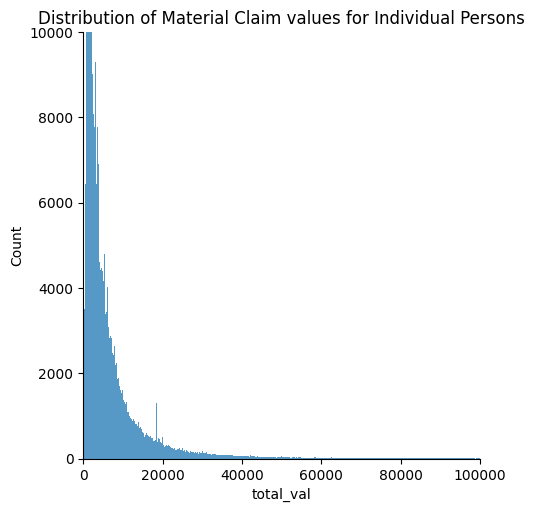

In [17]:
# quick plot of the distribution of material claims

fig = sns.displot(pf_mat, x = 'total_val')
fig.set(xlim = (0, 100000))
fig.set(ylim = (0, 10000))
plt.title('Distribution of Material Claim values for Individual Persons');

The shape is suggestive of the exponential distribution. This is in line with the expectations regarding the distribution of claim severity.

There are several subtypes of the exponential distribution that are used in actuarial investigations of severity:
1. Gamma
2. Log-normal 
3. Weibull
4. Inverse Gaussian 

### PF Mat

Fitting 4 distributions: 100%|██████████| 4/4 [00:08<00:00,  2.01s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
invgauss,0.00,34063.04,-14949994.86,inf,0.03,0.00
lognorm,0.00,7291.29,-14925275.85,inf,0.03,0.00
gamma,0.00,inf,-14872433.08,NaN,1.00,0.00
weibull,inf,inf,inf,inf,NaN,NaN


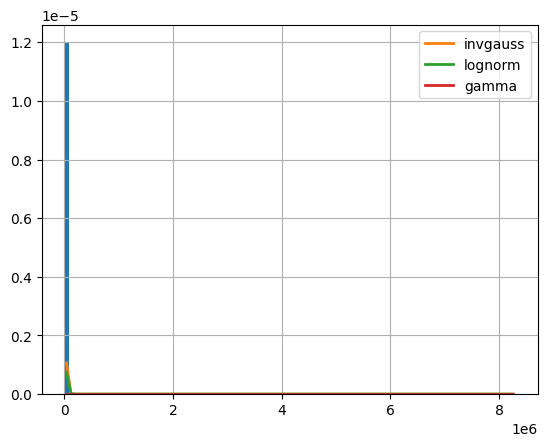

In [18]:
# use the Fitter (library) to identify which of the above 4 is the best
f = Fitter(pf_mat.total_val, distributions = ['gamma', 'lognorm', 'weibull', 'invgauss']) 
f.fit()
f.summary()

Log-normal appears to be the best fit, having a small sum of squared errors, the smallest AIC (Akaike Information Criterion) value, and the highest Kolmogorov-Smirnov statistic. 

First, a mored in depth investigation of the goodness of fit of the data (WITH OUTLIERS), i.e. how closely it ressembles the log-normal. 

In [19]:
# Statsmodels does not have Log-normal as a family, as such I will use the Gaussian family and
# will log transform the claim values column

pf_mat = pf_mat.assign(log_total_val = np.log(pf_mat.total_val))

patsy_null = 'log_total_val ~ 1'  # fitting the base model, no predictors just the target values
model_with_outliers = glm(patsy_null, data = pf_mat, family = sm.families.Gaussian()).fit()

model_with_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               417730
Model:                            GLM   Df Residuals:                   417729
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          1.1057
Method:                          IRLS   Log-Likelihood:            -6.1371e+05
Date:                Wed, 08 Feb 2023   Deviance:                   4.6187e+05
Time:                        09:52:27   Pearson chi2:                 4.62e+05
No. Iterations:                     3   Pseudo R-squ. (CS):          2.864e-12
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2723      0.002   5084.627      0.000       8.269       8.275
==============================================================================
"""

In [20]:
model_with_outliers.aic

1227430.0419695666

Now that there is a BASELINE goodness of fit with all data, I can begin to remove outliers and consider whether their removal makes improvements.

I will first manually remove some 'obvious' outliers, by this I mean values with a probability of happening less than 0.5% (this is a benchmark used by actuaries).



In [21]:
pf_mat.total_val.describe()

count    417730.00
mean       7286.88
std       20498.76
min           1.00
25%        1849.00
50%        3743.00
75%        7745.00
max     8293198.96
Name: total_val, dtype: float64

In [52]:
# bin claim values into multiple categories
bins = list(range(0, 100000, 10000)) 
labels = [str(bins[i])+'_'+ str(bins[i+1]) for i in range(0, len(bins)-1)]
pf_mat['val_cat'] = pd.cut(x = pf_mat.total_val, bins = bins, labels = labels, include_lowest = True)

In [53]:
# calculate frequency of each category
val_freq = pf_mat.groupby('val_cat', as_index=True).agg({'total_val':'count'})
val_freq['freq'] = (val_freq['total_val']/pf_mat.shape[0])*100
val_freq.tail(10)

,total_val,freq
val_cat,,
0_10000,341883,81.84
10000_20000,48930,11.71
20000_30000,13037,3.12
30000_40000,5749,1.38
40000_50000,2813,0.67
50000_60000,1625,0.39
60000_70000,1038,0.25
70000_80000,643,0.15
80000_90000,456,0.11


Categories above 60K contain a cumulative probability of about 0.5%, so, following from the 0.5% Rule, I will drop all events with a claim above 60k.

In [56]:
# drop the val_cat column
pf_mat.drop('val_cat', axis = 1, inplace = True)

# create a new dataframe with the dropped values
outliers = pf_mat.query("total_val > 60000").copy()

# drop the outliers from the main df
pf_mat.drop(pf_mat.query("total_val > 60000").index, axis = 0, inplace = True)
pf_mat.reset_index(drop=True, inplace=True)

Fitting 4 distributions: 100%|██████████| 4/4 [00:16<00:00,  4.18s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
invgauss,0.00,2578.41,-14174785.39,0.01,0.02,0.00
gamma,0.00,3584.90,-12300756.42,0.23,0.15,0.00
lognorm,0.00,2728.66,-11911337.61,0.84,0.73,0.00
weibull,inf,inf,inf,inf,NaN,NaN


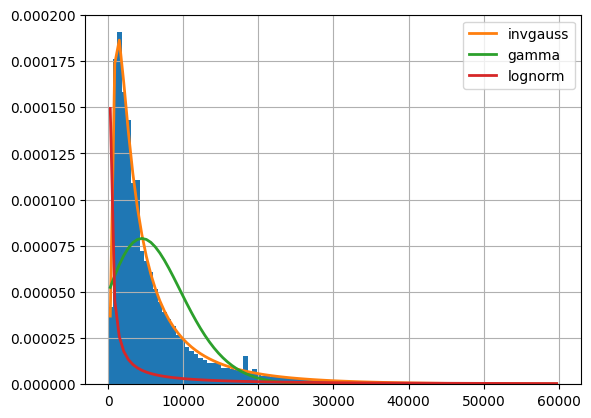

In [62]:
# re-use the Fitter to check whether the same distribution will get selected as the best
f = Fitter(pf_mat.total_val, distributions = ['gamma', 'lognorm', 'weibull', 'invgauss']) 
f.fit()
f.summary()

Inverse Gaussian has the smallest AIC score and visually the best fit, however, for a slightly increased AIC score, Log-normal has a much better KS score. 

I will use GLM to get more details about both:

In [64]:
# check the effect of manually dropping values >60k for LOG-NORMAL

patsy_null = 'log_total_val ~ 1'  # fitting the base model, no predictors just the target values
model_manual_LGN = glm(patsy_null, data = pf_mat, family = sm.families.Gaussian()).fit()

model_manual_LGN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               414037
Model:                            GLM   Df Residuals:                   414036
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          1.0230
Method:                          IRLS   Log-Likelihood:            -5.9221e+05
Date:                Wed, 08 Feb 2023   Deviance:                   4.2358e+05
Time:                        10:54:24   Pearson chi2:                 4.24e+05
No. Iterations:                     3   Pseudo R-squ. (CS):          2.917e-12
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2439      0.002   5244.536      0.000       8.241       8.247
==============================================================================
"""

In [65]:
# check the effect of manually dropping values >60k for INVERSE GAUSSIAN

patsy_null = 'total_val ~ 1'  # fitting the base model, no predictors just the target values
model_manual_IVG = glm(patsy_null, data = pf_mat, family = sm.families.InverseGaussian()).fit()

model_manual_IVG.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              total_val   No. Observations:               414037
Model:                            GLM   Df Residuals:                   414036
Model Family:         InverseGaussian   Df Model:                            0
Link Function:        inverse_squared   Scale:                      0.00023137
Method:                          IRLS   Log-Likelihood:            -4.0251e+06
Date:                Wed, 08 Feb 2023   Deviance:                       119.25
Time:                        10:54:29   Pearson chi2:                     95.8
No. Iterations:                     9   Pseudo R-squ. (CS):         -4.441e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.46e-08   9.29e-11    264.887      0.000    2.44e-08    2.48e-08
==============================================================================
"""

In [66]:
print(f'AIC scores for: \n Log-normal {model_manual_LGN.aic} \n Inverse Gaussian {model_manual_IVG.aic}')

AIC scores for: 
 Log-normal 1184419.5474458358 
 Inverse Gaussian 8050120.617742584


I will use 3 methods to identify outliers: 
1. Elliptic Envelope
2. Local outlier facor
3. Isolation Forest

#### Elliptic Envelope

In [68]:
# prepare the input
data = pf_mat.total_val.array.reshape(-1, 1)

# predict outliers
predictions = EllipticEnvelope().fit(data).predict(data)

# create col with predictions
pf_mat['ee_pred'] = predictions

# percentage of events identified as outliers
print(f'Percentage of events identified as outliers: {(pf_mat[pf_mat.ee_pred == -1].shape[0]/pf_mat.shape[0])*100}%')
# percentage of claim value identified as outlier:
print(f'Percentage of claim value identified as outlier: {(pf_mat[pf_mat.ee_pred == -1].total_val.sum()/pf_mat.total_val.sum())*100}%')

Percentage of events identified as outliers: 10.000072457292465%
Percentage of claim value identified as outlier: 39.623550657536335%


In [69]:
# obtain stats on the outliers
pf_mat[pf_mat.ee_pred == -1].total_val.describe()


count   41404.00
mean    25264.13
std     10121.17
min     15003.00
25%     18124.00
50%     21353.00
75%     29839.50
max     60000.00
Name: total_val, dtype: float64

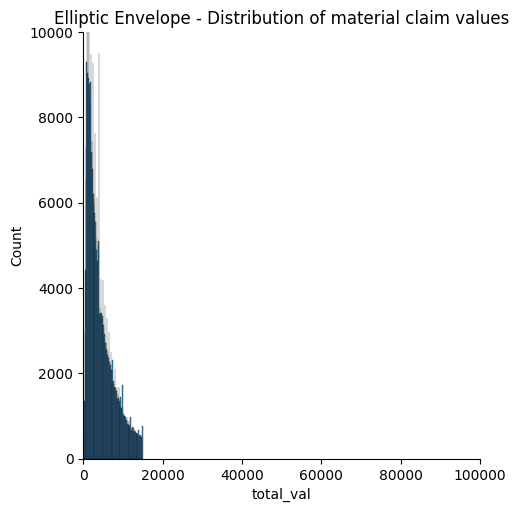

In [70]:
# plot of the distribution of material claims WITHOUT OUTLIERS

fig = sns.displot(pf_mat[pf_mat.ee_pred == 1], x = 'total_val')
fig.set(xlim = (0, 100000))
fig.set(ylim = (0, 10000))
plt.title('Elliptic Envelope - Distribution of material claim values');

In [71]:
# check goodness of fit after removing the identified outliers

patsy_null = 'log_total_val ~ 1'  # fitting the base model, no predictors just the target values
model_EE = glm(patsy_null, data = pf_mat[pf_mat.ee_pred == 1], family = sm.families.Gaussian()).fit()

model_EE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               372633
Model:                            GLM   Df Residuals:                   372632
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                         0.71116
Method:                          IRLS   Log-Likelihood:            -4.6524e+05
Date:                Wed, 08 Feb 2023   Deviance:                   2.6500e+05
Time:                        11:00:15   Pearson chi2:                 2.65e+05
No. Iterations:                     3   Pseudo R-squ. (CS):          3.601e-12
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.0410      0.001   5820.550      0.000       8.038       8.044
==============================================================================
"""

In [72]:
model_EE.aic

930474.6412037441

A noticeable improvement, at the cost of ~ 10% of the events.

#### Local Outlier Factor

In [73]:
# prepare the input
data = pf_mat.total_val.array.reshape(-1, 1)

# predict outliers
predictions = LocalOutlierFactor(n_neighbors=500, novelty=True).fit(data).predict(data)

# create col with predictions
pf_mat['lof_pred'] = predictions

# percentage of events identified as outliers
print(f'Percentage of events identified as outliers: {(pf_mat[pf_mat.lof_pred == -1].shape[0]/pf_mat.shape[0])*100}%')
# percentage of claim value identified as outlier:
print(f'Percentage of claim value identified as outlier: {(pf_mat[pf_mat.lof_pred == -1].total_val.sum()/pf_mat.total_val.sum())*100}%')

Percentage of events identified as outliers: 5.180213362573876%
Percentage of claim value identified as outlier: 2.727733260675928%


In [74]:
# obtain stats on the outliers
pf_mat[pf_mat.lof_pred == -1].total_val.describe()


count   21448.00
mean     3357.44
std      3656.09
min         1.00
25%      1097.00
50%      2103.00
75%      4006.00
max     19486.00
Name: total_val, dtype: float64

In [84]:
outliers.shape[0]

3693

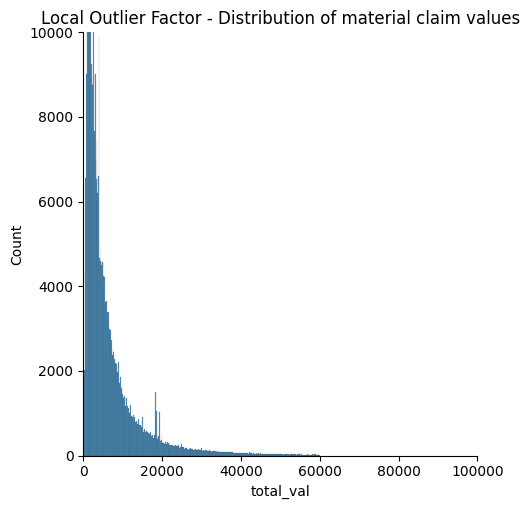

In [75]:
# plot of the distribution of material claims WITHOUT OUTLIERS

fig = sns.displot(pf_mat[pf_mat.lof_pred == 1], x = 'total_val')
fig.set(xlim = (0, 100000))
fig.set(ylim = (0, 10000))
plt.title('Local Outlier Factor - Distribution of material claim values');

In [76]:
# check goodness of fit after removing the identified outliers

patsy_null = 'log_total_val ~ 1'  # fitting the base model, no predictors just the target values
model_LOF = glm(patsy_null, data = pf_mat[pf_mat.lof_pred == 1], family = sm.families.Gaussian()).fit()

model_LOF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               392589
Model:                            GLM   Df Residuals:                   392588
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          1.0116
Method:                          IRLS   Log-Likelihood:            -5.5932e+05
Date:                Wed, 08 Feb 2023   Deviance:                   3.9713e+05
Time:                        11:02:46   Pearson chi2:                 3.97e+05
No. Iterations:                     3   Pseudo R-squ. (CS):          3.245e-12
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.2748      0.002   5155.000      0.000       8.272       8.278
==============================================================================
"""

In [77]:
model_LOF.aic

1118637.7284490815

#### Isolation forest

In [78]:

# prepare the input
data = pf_mat.total_val.array.reshape(-1, 1)

contaminations = [0.01, 0.05, 0.1]

for contamination in contaminations:
    random_state = np.random.RandomState(42)
    prediction = IsolationForest(n_estimators=100, max_samples='auto', contamination = contamination, 
                                    random_state=random_state).fit(data).predict(data)
    pf_mat[f'iso_pred_{contamination}'] = prediction



In [79]:
# percentage of events identified as outliers
print(f"Percentage of events identified as outliers: \n - At 1% contamination: {(pf_mat[pf_mat['iso_pred_0.01'] == -1].shape[0]/pf_mat.shape[0])*100}% \n - At 5% contamination: {(pf_mat[pf_mat['iso_pred_0.05'] == -1].shape[0]/pf_mat.shape[0])*100}% \n - At 10% contamination: {(pf_mat[pf_mat['iso_pred_0.1'] == -1].shape[0]/pf_mat.shape[0])*100}%")
# percentage of claim value identified as outlier:
print(f"Percentage of claim value identified as outlier: \n - At 1% contamination: {(pf_mat[pf_mat['iso_pred_0.01'] == -1].total_val.sum()/pf_mat.total_val.sum())*100}% \n - At 5% contamination: {(pf_mat[pf_mat['iso_pred_0.05'] == -1].total_val.sum()/pf_mat.total_val.sum())*100}% \n - At 10% contamination: {(pf_mat[pf_mat['iso_pred_0.1'] == -1].total_val.sum()/pf_mat.total_val.sum())*100}%")

Percentage of events identified as outliers: 
 - At 1% contamination: 0.9914572852184709% 
 - At 5% contamination: 4.997379461255878% 
 - At 10% contamination: 9.99186063081319%
Percentage of claim value identified as outlier: 
 - At 1% contamination: 7.588614709902215% 
 - At 5% contamination: 25.569954974327274% 
 - At 10% contamination: 38.283679834607774%


At 5% appears to be the greatest amount of money selected for the smallest number of events.

In [58]:
# obtain stats on the outliers
pf_mat[pf_mat['iso_pred_0.05'] == -1].total_val.describe()


count     20647.00
mean      48189.84
std       79402.65
min       23334.00
25%       28199.79
50%       35240.00
75%       50790.00
max     8293198.96
Name: total_val, dtype: float64

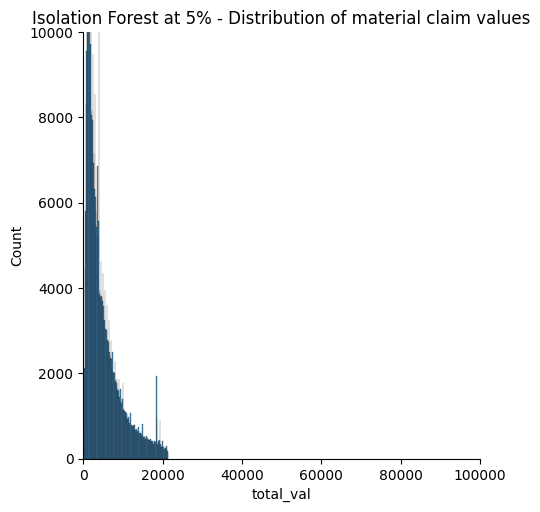

In [80]:
# plot of the distribution of material claims WITHOUT OUTLIERS

fig = sns.displot(pf_mat[pf_mat['iso_pred_0.05'] == 1], x = 'total_val')
fig.set(xlim = (0, 100000))
fig.set(ylim = (0, 10000))
plt.title('Isolation Forest at 5% - Distribution of material claim values');

In [81]:
# check goodness of fit after removing the identified outliers

patsy_null = 'log_total_val ~ 1'  # fitting the base model, no predictors just the target values
model_IS = glm(patsy_null, data = pf_mat[pf_mat['iso_pred_0.05'] == 1], family = sm.families.Gaussian()).fit()

model_IS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          log_total_val   No. Observations:               393346
Model:                            GLM   Df Residuals:                   393345
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                         0.82657
Method:                          IRLS   Log-Likelihood:            -5.2067e+05
Date:                Wed, 08 Feb 2023   Deviance:                   3.2513e+05
Time:                        11:06:39   Pearson chi2:                 3.25e+05
No. Iterations:                     3   Pseudo R-squ. (CS):          3.232e-12
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.1330      0.001   5610.451      0.000       8.130       8.136
==============================================================================
"""

In [82]:
model_IS.aic

1041348.5216208091

## Conclusion:

Out of the 3 methods, LOF was the most helpful since it also identified exceedingly small values as outlier, removing ~ 5% of events for the cost of only ~ 2.5% of the total value of the portfolio.

Henceforth, outliers will be those above 60k and those specifically identified by the LOF algorithm.

In [108]:
# rebuild the original df with all outliers and add a column with the outlier status of each row
# Outlier status will be: a) No Outlier; b) Outlier identified by LOF; c) Outlier above 60k

result_df = pd.concat([pf_mat, outliers], ignore_index = True)
result_df.fillna(2, inplace = True)
result_df.replace({'lof_pred' : { 1 : 'no_out', -1 : 'lof_out', 2 : '>60k_out' }}, inplace = True)
result_df.rename(columns = {'lof_pred' : 'outlier_type'}, inplace = True)
result_df.drop(['index', 'ee_pred', 'iso_pred_0.01', 'iso_pred_0.05', 'iso_pred_0.1'], axis = 1, inplace = True)

result_df.head()

,idEvent,total_val,idPolita,log_total_val,outlier_type
0,100001972018-12-02,10815.00,10000197,9.29,no_out
1,100004462018-10-08,2635.00,10000446,7.88,no_out
2,100005852018-07-07,9255.00,10000585,9.13,no_out
3,100006982018-05-27,5097.00,10000698,8.54,no_out
4,100007012018-08-09,18872.00,10000701,9.85,no_out


In [111]:
# save to S3

result_df.to_feather('autoturisme_pf_mat_outlier_status.feather')
s3con.write('autoturisme_pf_mat_outlier_status.feather')
os.remove('autoturisme_pf_mat_outlier_status.feather')